# Finetuning the model
To fine-tune a ConvNext model on our data using the HuggingFace API, we need to install the packages transformers and datasets in our colab notebook. If you are working in your enviorment, you also need to install torch, numpy, and tqdm to follow this tutorial.

In [1]:
!pip3 install transformers datasets
#uncomment the following line if you are running your own jupyter notebook in a fresh enviroment
#!pip3 install -q numpy tqdm torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
!pip3 install -q numpy tqdm torch torchvision torchaudio matplotlib

SyntaxError: invalid syntax (4098875122.py, line 1)

For reproducibility, we fix our seed to a value. Choosing the seed is up to you. In this case, I used the seed 2023 because it is the year 2023 at the time I am writing this.

In [2]:
seed = 2023

Now let's load our dataset. For this example, I use the pokemon-classification dataset from the user 
keremberke on hugging face.

After downloading the dataset, we can inspect it using a simple print call. For this dataset, we see that it has 4869 images in the train set and 732 on the test set, and the dataset comes even with a relatively extensive validation set of 1390 images. But for this tutorial, we will not use the validation set because the dataset is relatively small, and we want to use as much data as possible for our model.

In [3]:
from datasets import load_dataset, concatenate_datasets
dataset = load_dataset("keremberke/pokemon-classification", name="full")
dataset


Found cached dataset pokemon-classification (/home/studio-lab-user/.cache/huggingface/datasets/keremberke___pokemon-classification/full/1.0.0/5193d0f863ed08164636296506df483caa6c9965bc05198ec2136417398e4b28)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4869
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1390
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 732
    })
})

To convert between the class ids and the label name, we need to generate a mapping for id2label and label2id. These maps will also be used for loading the pre-trained model. 

In [4]:
labels = dataset["train"].features["labels"].names
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}

Now that we have our mapping, we should investigate the dataset a bit more before starting to process the dataset. Let's look into the distribution of the classes in the train set.

First, we write a function that counts every occurrence of each label in the train and test dataset, then we normalize the result and plot the difference between them.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def normalize(d, target=1.0):
   raw = sum(d.values())
   factor = target/raw
   return {key:value*factor for key,value in d.items()}

def getLabelDistribution(dataset, split):
  labels = dataset[split].features["labels"].names
  dist = {k:0 for k in labels}

  for row in dataset[split]:
    dist[id2label[row['labels']]] +=1

  return normalize(dist)

def get_diff(train_dist, test_dist):
  labels = list()
  diffs = list()
  for (k,v_train), (_ ,v_test) in zip(train_dist.items(), test_dist.items()):
    diff = abs(v_train - v_test) * 100
    labels.append(k)
    diffs.append(diff)

  y_pos = np.arange(len(labels))
  plt.bar(y_pos, diffs)
  plt.show()

The plot looks like the classes are unevenly distributed, but that is not a problem for us because we wanted to use the validation dataset for training anyway. So let us merge all three datasets into one and create our own test/train splits.

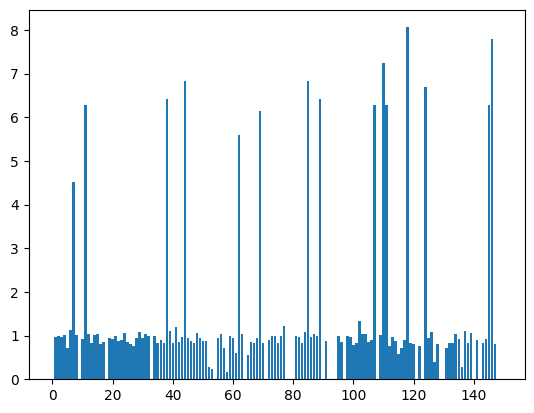

In [6]:
train_dist = getLabelDistribution(dataset, "train")
test_dist = getLabelDistribution(dataset, "test")
get_diff(train_dist, test_dist)

First, we merge all the datasets into one Dataset object, and then we create a new DatasetDict object with the train_test_split function. For the test_size, I choose 20%, but you can experiment with that value and see if another size works better. It is only essential to set stratify_by_column to labels to distribute the labels evenly.  

In [7]:
dataset = concatenate_datasets([dataset["train"], dataset["validation"], dataset["test"]])
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="labels")

When we look at the plot now, the difference in the class distribution between the test and train datasets is significantly smaller. 

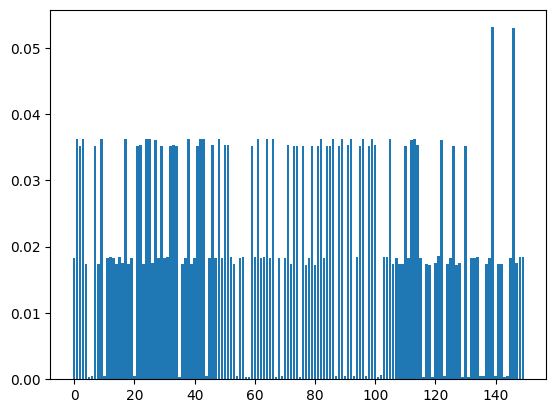

In [8]:
train_dist = getLabelDistribution(dataset, "train")
test_dist = getLabelDistribution(dataset, "test")
get_diff(train_dist, test_dist)

Now we import and use the ConvNextFeatureExtractor from the transformers library of the hugging face API and load the model config from the pre-trained model. You don't need to do that, but it helps when exploring a new model, and I think it is pretty convenient for the transformer pipeline.

In [9]:
from transformers import ConvNextFeatureExtractor

feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


Now we build two transform pipelines, one for the train data and one for the test data. The main difference between both pipelines is that the train pipeline has image augmentations to prevent overfitting during training. The test pipeline has only the necessary steps to prepare the data for the model. Then we convert the image to rgb values and apply the transformation.

In [10]:
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
size = feature_extractor.size["shortest_edge"]

transform_train = Compose(
    [
     RandomResizedCrop(size),
     RandomHorizontalFlip(),
     ToTensor(),
     normalize
    ]
)
transform_test = Compose(
    [
      Resize(size),
      ToTensor(),
      normalize
    ]
)

def train_transforms(examples):
  examples["pixel_values"] = [transform_train(image.convert("RGB")) for image in examples["image"]]
  return examples

def test_transforms(examples):
  examples["pixel_values"] = [transform_test(image.convert("RGB")) for image in examples["image"]]
  return examples

train_dataset = dataset["train"].with_transform(train_transforms)
test_dataset = dataset["test"].with_transform(test_transforms)


Using the AutoModelForImageClassification Class, we can download the pre-trained model and change the size of the output layer to the number of our labels in the dataset. We also provide it with our id2label and label2id maps and set the parameter ignore_mismatched_sizes to True, so we can change the last layer without throwing an error.

In [11]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([150, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([150]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


To use the GPU for training and testing, we push the model to the GPU if one is available.

In [12]:
import torch 
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

We define a custom collate_fn function. This function is applied to the batch of samples before they are passed to the model for training or evaluation. We use collate_fn to define how to preprocess the input data to obtain equally sized tensors.

We enable shuffling for the train_dataloader and set our previously defined seed for the random function. In this example, I choose a batch_size of 4 because the dataset is relatively small, but you can experiment with that value.

In [13]:
from torch.utils.data import DataLoader
import numpy as np

def collate_fn(examples):
  pixel_values = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["labels"] for example in examples])

  return {"pixel_values": pixel_values, "labels": labels}

batch_size = 4
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(seed))
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size)

To train and test our model, we need to write the test and train function. The test function starts with setting the model in the evaluation mode. In this mode the model doesn't update the its parameters. 

We iterate over all batches, pushing them to the GPU if one is available,  passing them through the model, and calculating their loss value.

In [20]:
from tqdm.notebook import tqdm
def test(model, dataloader):
  print("Starting testing")
  results = list()
  model.eval()

  correct = 0
  total = 0
  t_loss = 0.

  with tqdm(dataloader, unit=" it") as tepoch:
    for idx, batch in enumerate(tepoch):
      tepoch.set_description(f"Testing model")
      # move batch to GPU
      batch = {k:v.to(device) for k,v in batch.items()}
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"],
                          labels=batch["labels"])
          
      loss, logits = outputs.loss, outputs.logits

      # metrics
      total += batch["labels"].shape[0]
      predicted = logits.argmax(-1)
      correct += (predicted == batch["labels"]).sum().item()
      t_loss += loss.item()
      tepoch.set_postfix(loss=t_loss/total, accuracy=100. * correct/total)
  acc = 100. * correct/total
  print(f"Test completed!\nAverage accuracy: {acc:.3f}%")

We do almost the same for the train function, but instead of model.eval(), we set the model to model.train(). We also define an optimizer to reduce the loss while training.

In [23]:
def train(model, dataloader, epochs):
  print("Starting Training:")
  optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
  
  model.train()
  for epoch in range(epochs):
    correct = 0
    total = 0
    t_loss = 0.

    with tqdm(dataloader) as tepoch:
      for idx, batch in enumerate(tepoch):
        # move batch to GPU
        tepoch.set_description(f"Epoch {epoch}/{epochs-1}")
        batch = {k:v.to(device) for k,v in batch.items()}

        #reset the gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"],
                        labels=batch["labels"])
        
        loss, logits = outputs.loss, outputs.logits
        # back propagate 
        loss.backward()
        optimizer.step()

        # metrics
        total += batch["labels"].shape[0]
        predicted = logits.argmax(-1)
        correct += (predicted == batch["labels"]).sum().item()
        t_loss += loss.item()

        tepoch.set_postfix(loss=t_loss/total, accuracy=100. * correct/total)

Now let's test our test set on the pre-trained model to see how it performs without training.

In [16]:
test(model, test_dataloader)

Starting testing


  0%|          | 0/350 [00:00<?, ? it/s]

Test completed!
Average accuracy: 0.715%


As you can see, it performs terribly on our data. Now let us change that. We train our model with our data for ten epochs. This can take up to 30 min on a google colab.

In [24]:
train(model, train_dataloader, 10)

Starting Training:


  0%|          | 0/1398 [00:00<?, ?it/s]

  0%|          | 0/1398 [00:00<?, ?it/s]

  0%|          | 0/1398 [00:00<?, ?it/s]

  0%|          | 0/1398 [00:00<?, ?it/s]

  0%|          | 0/1398 [00:00<?, ?it/s]

  0%|          | 0/1398 [00:00<?, ?it/s]

  0%|          | 0/1398 [00:00<?, ?it/s]

  0%|          | 0/1398 [00:00<?, ?it/s]

  0%|          | 0/1398 [00:00<?, ?it/s]

  0%|          | 0/1398 [00:00<?, ?it/s]

Finally we can test our model again!

In [25]:
test(model, test_dataloader)

Starting testing


  0%|          | 0/350 [00:00<?, ? it/s]

Test completed!
Average accuracy: 95.926%


Congratulation, you successfully fine-tuned a ConvNeXt model. You can use the same approach for almost any deep neural network.